# Importing Packages

In [1]:
import pandas as pd
import requests
import pickle
import warnings
warnings.filterwarnings("ignore")

from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.svm import SVC
from sklearn.pipeline import Pipeline

import sys
sys.path.append("../py/")
from config import keys

import re
import gensim
from nltk.stem import WordNetLemmatizer

from sklearn.metrics import precision_score, recall_score, accuracy_score, f1_score, auc, average_precision_score, confusion_matrix, roc_auc_score
from tqdm import tqdm
import pandas as pd
import numpy as np
import requests
import matplotlib.pyplot as plt
import seaborn as sns


# Twitter API and Importing Datasets

In [5]:
def group_list(lst, size=100):
    new_list =[]
    idx = 0
    while idx < len(lst):        
        new_list.append(','.join([str(item) for item in lst[idx:idx+size]]))
        idx += size
    return new_list

def tweets_request(tweets_ids):
    lst = []
    for batch in tqdm(tweets_ids):
        url = "https://api.twitter.com/2/tweets?ids={}&&tweet.fields=created_at,entities,geo,id,public_metrics,text&user.fields=description,entities,id,location,name,public_metrics,username".format(batch)
        payload={}
        headers = {'Authorization': 'Bearer ' + keys['bearer_token'],
        'Cookie': 'personalization_id="v1_hzpv7qXpjB6CteyAHDWYQQ=="; guest_id=v1%3A161498381400435837'}
        r = requests.request("GET", url, headers=headers, data=payload)
        data = r.json()
        if 'data' in data.keys():
            lst.append(pd.DataFrame(data['data']))
    return pd.concat(lst)

## Davidson Dataset

In [6]:
df = pd.read_csv("../data/original/labeled_data.csv", index_col=0)
df.head()

,count,hate_speech,offensive_language,neither,class,tweet
0,3,0,0,3,2,!!! RT @mayasolovely: As a woman you shouldn't...
1,3,0,3,0,1,!!!!! RT @mleew17: boy dats cold...tyga dwn ba...
2,3,0,3,0,1,!!!!!!! RT @UrKindOfBrand Dawg!!!! RT @80sbaby...
3,3,0,2,1,1,!!!!!!!!! RT @C_G_Anderson: @viva_based she lo...
4,6,0,6,0,1,!!!!!!!!!!!!! RT @ShenikaRoberts: The shit you...


In [7]:
df = df.drop(columns=['count', 'hate_speech', 'offensive_language', 'neither'], axis=1)
df.columns = ['label', 'text']
df.label.value_counts()

1    19190
2     4163
0     1430
Name: label, dtype: int64

In [8]:
df = df.replace({'label': {1: 0, 2: 0, 0: 1}})
df.label.value_counts()

0    23353
1     1430
Name: label, dtype: int64

In [9]:
df.head()

,label,text
0,0,!!! RT @mayasolovely: As a woman you shouldn't...
1,0,!!!!! RT @mleew17: boy dats cold...tyga dwn ba...
2,0,!!!!!!! RT @UrKindOfBrand Dawg!!!! RT @80sbaby...
3,0,!!!!!!!!! RT @C_G_Anderson: @viva_based she lo...
4,0,!!!!!!!!!!!!! RT @ShenikaRoberts: The shit you...


## Aristotle Dataset

In [10]:
df2 = pd.read_csv("../data/original/hatespeechtwitter.csv")
df2.head()

,tweet_id,maj_label
0,849667487180259329,abusive
1,850490912954351616,abusive
2,848791766853668864,abusive
3,848306464892604416,abusive
4,850010509969465344,normal


In [11]:
df2.columns = ['id', 'label']
df2.label.value_counts()

normal     52835
spam       13404
abusive    10122
hateful     3635
Name: label, dtype: int64

In [12]:
# setup url and headers for calling Twitter API as per documentation
url = "https://api.twitter.com/2/tweets?ids=847661947159891972,847799130277675008,848933211375779840&tweet.fields=created_at,entities,geo,id,public_metrics,text&user.fields=description,entities,id,location,name,public_metrics,username"
payload={}
headers = {'Authorization': 'Bearer ' + keys['bearer_token'], 'Cookie': 'personalization_id="v1_hzpv7qXpjB6CteyAHDWYQQ=="; guest_id=v1%3A161498381400435837'}

# make GET request to Twitter API to get response object 
r = requests.request("GET", url, headers=headers, data=payload)

# convert payload to dictionary
data = r.json()

In [13]:
df_hateful = df2[df2['label']=='hateful']
hate_ids = group_list(list(df_hateful.id))

In [14]:
df_hate = tweets_request(hate_ids)

100%|██████████| 37/37 [00:24<00:00,  1.48it/s]


In [20]:
df_hate

,public_metrics,created_at,text,id,entities,geo
0,"{'retweet_count': 0, 'reply_count': 0, 'like_c...",2017-04-07T19:42:40.000Z,I hate er chase because if the Bitch that work...,850433664890544128,NaN,NaN
1,"{'retweet_count': 5, 'reply_count': 0, 'like_c...",2017-04-06T21:39:45.000Z,RT @nyctophil3: Pineapples do not belong on pi...,850100742035836929,"{'mentions': [{'start': 3, 'end': 14, 'usernam...",NaN
2,"{'retweet_count': 0, 'reply_count': 0, 'like_c...",2017-03-31T13:35:20.000Z,Niggas keep talking about women wearing weave ...,847804507367100416,NaN,NaN
3,"{'retweet_count': 0, 'reply_count': 1, 'like_c...",2017-04-06T20:58:20.000Z,@vappywave idiot that's not gonna work. you go...,850090319165050880,"{'mentions': [{'start': 0, 'end': 10, 'usernam...",NaN
4,"{'retweet_count': 5, 'reply_count': 0, 'like_c...",2017-04-03T00:00:48.000Z,RT @ayevonnn: bruh i fucking hate people like ...,848686686930382848,"{'urls': [{'start': 53, 'end': 76, 'url': 'htt...",NaN
...,...,...,...,...,...,...
19,"{'retweet_count': 0, 'reply_count': 0, 'like_c...",2017-04-08T13:25:50.000Z,Baekhyun won 'Most Popular Artist of Korea'\n\...,850701219568001025,"{'annotations': [{'start': 0, 'end': 7, 'proba...",NaN
20,"{'retweet_count': 0, 'reply_count': 1, 'like_c...",2017-04-04T17:42:11.000Z,#TripleTalaqArrest 2fgt dis social menace #Tri...,849316180670259205,"{'hashtags': [{'start': 0, 'end': 18, 'tag': '...",NaN
21,"{'retweet_count': 0, 'reply_count': 0, 'like_c...",2017-04-05T17:26:51.000Z,White nationalists' latest tactic to recruit c...,849674709763358720,"{'urls': [{'start': 85, 'end': 108, 'url': 'ht...",NaN
22,"{'retweet_count': 1, 'reply_count': 0, 'like_c...",2017-04-04T13:06:00.000Z,We are in a comfortable lead fight against gal...,849246676854484992,"{'hashtags': [{'start': 53, 'end': 66, 'tag': ...",NaN


In [15]:
df_2 = df_hate.reset_index(drop=True)
df_2['label'] = 1
df_2 = df_2[['text', 'label']]
df_2.head()

,text,label
0,I hate er chase because if the Bitch that work...,1
1,RT @nyctophil3: Pineapples do not belong on pi...,1
2,Niggas keep talking about women wearing weave ...,1
3,@vappywave idiot that's not gonna work. you go...,1
4,RT @ayevonnn: bruh i fucking hate people like ...,1


## University of Copenhagen Dataset

In [16]:
df3 = pd.read_csv('../data/original/NAACL_SRW_2016.csv', header=None)
df3.head()

,0,1
0,572342978255048705,racism
1,572341498827522049,racism
2,572340476503724032,racism
3,572334712804384768,racism
4,572332655397629952,racism


In [17]:
df3.columns = ['id', 'label']
df3.label.value_counts()

none      11559
sexism     3378
racism     1970
Name: label, dtype: int64

In [18]:
df_racsex = df3[(df3['label']=='racism') | (df3['label']=='sexism')]
racsex_id = group_list(list(df_racsex.id))
df_rac_sex = tweets_request(racsex_id)

100%|██████████| 54/54 [00:26<00:00,  2.01it/s]


In [19]:
df_3 = df_rac_sex.reset_index(drop=True)
df_3['label'] = 1
df_3 = df_3[['text', 'label']]
df_3.head()

,text,label
0,So Drasko just said he was impressed the girls...,1
1,Drasko they didn't cook half a bird you idiot ...,1
2,Hopefully someone cooks Drasko in the next ep ...,1
3,of course you were born in serbia...you're as ...,1
4,These girls are the equivalent of the irritati...,1


## HASOC Dataset

In [20]:
df4 = pd.read_csv("../data/original/english_dataset.tsv", delimiter = "\t")
df4.head()

,text_id,text,task_1,task_2,task_3
0,hasoc_en_1,#DhoniKeepsTheGlove | WATCH: Sports Minister K...,NOT,NONE,NONE
1,hasoc_en_2,@politico No. We should remember very clearly ...,HOF,HATE,TIN
2,hasoc_en_3,@cricketworldcup Guess who would be the winner...,NOT,NONE,NONE
3,hasoc_en_4,Corbyn is too politically intellectual for #Bo...,NOT,NONE,NONE
4,hasoc_en_5,All the best to #TeamIndia for another swimmin...,NOT,NONE,NONE


In [21]:
df_4 = df4[df4.task_2 == 'HATE']
df_4['label'] = 1
df_4 = df_4[['text', 'label']]
df_4.head()

,text,label
1,@politico No. We should remember very clearly ...,1
11,I don’t know how much more I can take! 45 is a...,1
23,#ShameOnICC 1. ICC on Dhoni's gloves ...,1
27,Disgusting! And they don’t change their cultur...,1
34,"@TheRealOJ32 Of all the retired NFL players, w...",1


## Combined Dataframe

In [22]:
combined = pd.concat([df, df_2, df_3, df_4], ignore_index=True)
combined.label.value_counts()

0    23353
1     7000
Name: label, dtype: int64

In [23]:
# separate into hate and not-hate subsets
hate = combined[combined.label == 1]
not_hate = combined[combined.label == 0]

# separate into features and target for train_test_aplit
X_hate = hate.text
y_hate = hate.label
X_not_hate = not_hate.text
y_not_hate = not_hate.label

# perform 80-20 split on dataset
X_hate_tr, X_hate_val, y_hate_tr, y_hate_val = train_test_split(X_hate, y_hate, test_size=0.20, random_state=42)
X_not_hate_tr, X_not_hate_val, y_not_hate_tr, y_not_hate_val = train_test_split(X_not_hate, y_not_hate, test_size=0.20, random_state=42)

# concatenate to reform training and validation dataset
X_train = pd.concat((X_hate_tr, X_not_hate_tr), ignore_index=True)
y_train = pd.concat((y_hate_tr, y_not_hate_tr), ignore_index=True)
train = pd.concat([X_train, y_train], axis=1)

X_val = pd.concat((X_hate_val, X_not_hate_val), ignore_index=True)
y_val = pd.concat((y_hate_val, y_not_hate_val), ignore_index=True)
valid = pd.concat([X_val, y_val], axis=1)

In [32]:
train.head()

,text,label
0,RT @IsaidNick: niggers are so ignorant http://...,1
1,"RT @grexican: @YesYoureSexist By the way, your...",1
2,@anniekfox So if he hit her in the same way fo...,1
3,This Atascadero woman is accusing of physicall...,1
4,Don't know y no rain in England's match . Does...,1


# Preprocessing Tweets

In [4]:
def preprocess(tweet):
    result = re.sub(r'(RT\s@[A-Za-z]+[A-Za-z0-9-_]+)', '', tweet)
    result = re.sub(r'(@[A-Za-z0-9-_]+)', '', result)
    result = re.sub(r'http\S+', '', result)
    result = re.sub(r'bit.ly/\S+', '', result) 
    result = re.sub(r'&[\S]+?;', '', result)
    result = re.sub(r'#', ' ', result)
    result = re.sub(r'[^\w\s]', r'', result)    
    result = re.sub(r'\w*\d\w*', r'', result)
    result = re.sub(r'\s\s+', ' ', result)
    result = re.sub(r'(\A\s+|\s+\Z)', '', result)
    result = tokenize(result)
    return result 

def lemmatize(token):
    return WordNetLemmatizer().lemmatize(token, pos='v')

def tokenize(tweet):
    result = []
    for token in gensim.utils.simple_preprocess(tweet):
        if token not in gensim.parsing.preprocessing.STOPWORDS and len(token) > 2:  # drops stopwords and words with <3 characters
            result.append(lemmatize(token))
    result = ' '.join(result)
    return result

In [24]:
train_processed = train.text.apply(lambda x: preprocess(x))
train_processed.head()

0                                     niggers ignorant
1    right package obligations ignore obligations s...
2                                         hit way wear
3    live lawless country wish walk flagstaff house...
4    icc doesnt care rain spoil sport protect rain ...
Name: text, dtype: object

In [25]:
valid_processed = valid.text.apply(lambda x: preprocess(x))
valid_processed.head()

0    doctor turn mamatas invite demand apology doct...
1    susan rice piece come know unmask trump right ...
2    yall break yall mad yall miserable unhappy bit...
3                                     sit stfu raghead
4      use term opposite shady source non shady source
Name: text, dtype: object

# Modeling and Evaluation

In [3]:
def aps(X, y, model):
    probs = model.decision_function(X)
    return average_precision_score(y, probs)

def auc(X, y, model):
    probs = model.decision_function(X) 
    return roc_auc_score(y, probs)

def get_metrics(X, y, y_pred, model):
    acc = accuracy_score(y, y_pred)
    f1 = f1_score(y, y_pred)
    rec = recall_score(y, y_pred)
    prec = precision_score(y, y_pred)
    rocauc = auc(X, y, model)
    prauc = aps(X, y, model)
    
    print('Accuracy: ', acc)
    print('F1: ', f1)
    print('Recall: ', rec)
    print('Precision: ', prec)
    print('ROC-AUC: ', rocauc)
    print('PR-AUC: ', prauc)

def get_confusion(y, y_pred):
    cnf = confusion_matrix(y, y_pred)
    group_names = ['TN','FP','FN','TP']
    group_counts = ['{0:0.0f}'.format(value) for value in cnf.flatten()]
    group_percentages = ['{0:.2%}'.format(value) for value in cnf.flatten()/np.sum(cnf)]
    labels = [f'{v1}\n{v2}\n{v3}' for v1, v2, v3 in zip(group_names, group_counts, group_percentages)]
    labels = np.asarray(labels).reshape(2,2)
    fig, ax = plt.subplots(figsize=(4,4))
    sns.heatmap(cnf, annot=labels, fmt='', cmap='Blues', annot_kws={'size':14}, cbar=False, xticklabels=False, yticklabels=False)

In [46]:
X_tr = train_processed.values
X_val = valid_processed.values
y_tr = train.label.values
y_val = valid.label.values

vec = TfidfVectorizer()
tfidf_tr = vec.fit_transform(X_tr)
tfidf_val = vec.transform(X_val)

In [47]:
pickle.dump(vec, open("vec.pickle", "wb"))

In [35]:
X_val

array(['doctor turn mamatas invite demand apology doctorsprotest mamatabanarjee',
       'susan rice piece come know unmask trump right little bitch',
       'yall break yall mad yall miserable unhappy bitch sit bench', ...,
       'judge bird account wouldnt cause ripple ocean',
       'kinda screw guinea pig experiment taste instead get interest result',
       'little closer bitch'], dtype=object)

In [27]:
clf = SVC(C=1, gamma=1, kernel='rbf', random_state=42, probability=True).fit(tfidf_tr, y_tr)
y_pred = clf.predict(tfidf_val)
get_metrics(tfidf_val, y_val, y_pred, clf)

Accuracy:  0.9156646351507165
F1:  0.7917005695687551
Recall:  0.695
Precision:  0.9196597353497165
ROC-AUC:  0.9481027311374133
PR-AUC:  0.8952112370346422


In [46]:
type(tfidf_val)

scipy.sparse.csr.csr_matrix

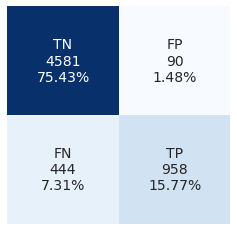

In [36]:
get_confusion(y_val, y_pred)

In [28]:
pickle.dump(clf, open("clf.pickle", "wb"))

In [ ]:
pickle_model = pickle.load(open(clf.pickle, 'rb'))

# Prediction

In [48]:
str1 = "@canelo28969897 @ItsCandyyyyyyy @DiamondRhona @darrel30901325 @Noblenosey Don’t nobody want no damn white man ew &amp;… https://t.co/cuzxJAzFGL" 
str2 = "@user lol speak for your own hazara(mongol) people who have nothing to do with ethnic afghans (nor genetical\u2026 @URL"
str3 = "i am going to the store to get some broccoli and cheese, any suggestions on cheese?"


In [57]:
def preprocess_tweet(tweet):
    result = re.sub(r'(RT\s@[A-Za-z]+[A-Za-z0-9-_]+)', '', tweet)
    result = re.sub(r'(@[A-Za-z0-9-_]+)', '', result)
    result = re.sub(r'http\S+', '', result)
    result = re.sub(r'bit.ly/\S+', '', result) 
    result = re.sub(r'&[\S]+?;', '', result)
    result = re.sub(r'#', ' ', result)
    result = re.sub(r'[^\w\s]', r'', result)    
    result = re.sub(r'\w*\d\w*', r'', result)
    result = re.sub(r'\s\s+', ' ', result)
    result = re.sub(r'(\A\s+|\s+\Z)', '', result)
    processed = tokenize(result)
    lst = []
    lst.append(processed)
    return lst 

In [58]:
str_1 = preprocess_tweet(str1)
str_1

['dont want damn white man']

In [59]:
vec_1 = vec.transform(str_1)
vec_1

<1x20303 sparse matrix of type '<class 'numpy.float64'>'
	with 5 stored elements in Compressed Sparse Row format>

In [61]:
pred_1 = clf.predict(vec_1)
pred_1

array([1])

In [62]:
prob_1 = clf.predict_proba(vec_1)[:,1]
print(prob_1)

[0.71777982]


In [63]:
prob_0 = clf.predict_proba(vec_1)[:,0]
print(prob_0)

[0.28222018]


In [64]:
mapping = {0: 'Same tweet different day', 1: 'Why you gotta be so hateful?'}
print(mapping[pred_1[0]])

Why you gotta be so hateful?


In [66]:
str_2 = preprocess_tweet(str2)
vec_2 = vec.transform(str_2)
pred_2 = clf.predict(vec_2)
print("Classification: ", pred_2[0])
prob_2 = clf.predict_proba(vec_2)[:,1]
print("Probability: ", prob_2[0])
print("Message; ", mapping[pred_2[0]])

Classification:  1
Probability:  0.8676186630332309
Message;  Why you gotta be so hateful?
